In [1]:
# 导入模块
import pandas as pd
import numpy as np
from sklearn import ensemble, preprocessing, metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.utils import shuffle
import math
import matplotlib.pyplot as plt
import random
import time

#SVM
from sklearn import svm

In [2]:
# 取经纬度的近似值

def appro(x):
    return round(x, 2)

In [3]:
# 处理weather数据集
def weather_process(dataframe):
    dataframe = dataframe.drop('CodeSum', axis=1)
    dataframe = dataframe.drop('StnPressure', axis=1)
    dataframe = dataframe.drop('SeaLevel', axis=1)
    dataframe = dataframe.drop('PrecipTotal', axis=1)
    dataframe = dataframe.drop('Water1', axis=1)
    dataframe = dataframe.drop('Depth', axis=1)
    weather_stn1 = dataframe[dataframe['Station'] == 1]
    weather_stn2 = dataframe[dataframe['Station'] == 2]
    weather_stn1 = weather_stn1.drop('Station', axis=1)
    weather_stn2 = weather_stn2.drop('Station', axis=1)
    dataframe = weather_stn1.merge(weather_stn2, on='Date')
    dataframe = dataframe.replace('-', -1)
    dataframe = dataframe.replace('M', -1)
    dataframe = dataframe.replace('  T', -1)
    return dataframe

In [4]:
# 处理train，test数据集
def train_process(dataframe):
    dataframe['Month'] = dataframe.Date.apply(create_month)
    dataframe['Day'] = dataframe.Date.apply(create_day)
    dataframe['Lat_appro'] = dataframe.Latitude.apply(appro)
    dataframe['Long_appro'] = dataframe.Longitude.apply(appro)
    dataframe = dataframe.drop(['Address', 'Block', 'Street'], axis=1)
    return dataframe

In [5]:
# 分割日期数据

def create_month(x):
    return x.split('-')[1]

def create_day(x):
    return x.split('-')[2]

In [6]:
# 使用数据集
train0 = pd.read_csv('train.csv')
weather = pd.read_csv('weather.csv')
tot = train0.shape[0]
# DataFrame 是一个表格型的数据结构，它含有一组有序的列，每列可以是不同的值类型（数值、字符串、布尔型值）。
# DataFrame 既有行索引也有列索引，它可以被看做由 Series 组成的字典（共同用一个索引）。

In [7]:
# 预处理数据，将标签编码，得到物种、位置以及陷阱对应的编码值

def encode_data(dataframe):
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train0['Species'].values))
    dataframe['Species'] = lbl.transform(dataframe['Species'].values)
    lbl.fit(list(train0['Trap'].values))
    dataframe['Trap'] = lbl.transform(dataframe['Trap'].values)
    lbl.fit(list(train0['AddressNumberAndStreet'].values))
    dataframe['AddressNumberAndStreet'] = lbl.transform(dataframe['AddressNumberAndStreet'].values)
    return dataframe

In [8]:
# 根据日期将天气数据与训练集测试集合并

def join_process(data, weather):
    data = data.merge(weather, on='Date')
    data = data.drop(['Date'], axis=1)
    return data

In [9]:
# 剔除坏数据，切片得到有效数据

def slice_data(dataframe):
    label = dataframe.WnvPresent.values
    train = dataframe.drop(['WnvPresent'], axis=1)
    return [train,label]

In [10]:
def drawRoc (fpr,tpr,AREA):
    plt.subplots(figsize=(7,5.5))
    plt.plot(fpr,tpr,color='darkorange', lw =2 , label = 'ROC curve (area = %0.2f)' %AREA)
    plt.plot([0,1],[0,1],color='navy',lw=2,linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('RoC Curve')
    plt.legend(loc="lower right")
    plt.show()

In [28]:
def solve(sz,train0):
    shit2=float(0)
    shit3=float(0)
    for i in range (0,2,1):
        train0=shuffle(train0)
        train = train0[:sz].copy()
        test = train0[sz:].copy()
        train = slice_data(encode_data(join_process(train_process(train), weather_process(weather))))
        test = slice_data(encode_data(join_process(train_process(test), weather_process(weather))))
        # 训练随机森林模型

        e = time.time()
        clf = ensemble.RandomForestClassifier(n_jobs=-1, n_estimators=1000, min_samples_split=50)
        # 声明SVM
        mdlinear =  svm.SVC(kernel = 'linear')
        mdpoly = svm.SVC(kernel = 'poly')
        #add train[0] x_train, train[1] y_training
        
        clf.fit(train[0], train[1])
        y_score = clf.predict_proba(test[0])
        
        #SVM training and test
        mdlinear.fit(train[0], train[1])
        ly_score = mdlinear.decision_function(test[0])
        mdpoly.fit(train[0], train[1])
        py_score = mdpoly.decision_function(test[0])
        #add
        s = time.time()
        print(clf.classes_)
        print('training time: '+str(s-e) + 's')
        fpr, tpr, thresholds = roc_curve(test[1],y_score[:,1])
        #svmroc
        lfpr, ltpr, thresholds = roc_curve(test[1],ly_score)
        pfpr, ptpr, thresholds = roc_curve(test[1],py_score)
        #AUC
        predictions = clf.predict_proba(test[0])[:,1]
        #svmauc
        lpredictions = mdlinear.decision_function(test[0])
        ppredictions = mdpoly.decision_function(test[0])
        #test[0] xtest test[1] ytest
        AREA=roc_auc_score(test[1], predictions, multi_class='ovo')
        #svnauc
        lAREA=roc_auc_score(test[1], lpredictions, multi_class='ovo')
        pAREA=roc_auc_score(test[1], ppredictions, multi_class='ovo')
        shit2 = shit2 + AREA
        print(AREA)
        print(lAREA)
        print(pAREA)
        #准确率
        predictions = clf.predict(test[0])
        #svm
        lpredictions = mdlinear.predict(test[0])
        ppredictions = mdpoly.predict(test[0])
        
        ACCscore = metrics.accuracy_score(test[1], predictions)
        lACCscore = metrics.accuracy_score(test[1], lpredictions)
        pACCscore = metrics.accuracy_score(test[1], ppredictions)
        shit3 = shit3 + ACCscore
        print(ACCscore)
        print(lACCscore)
        print(pACCscore)
        print("%.2f" % (sz/tot))
        drawRoc(fpr,tpr,AREA)
        drawRoc(lfpr,ltpr,lAREA)
        drawRoc(pfpr,ptpr,pAREA)
    
    shit2=shit2/2
    shit3=shit3/2
    return shit2,shit3

[0 1]
training time: 7.494320631027222s
0.8768402503727089
0.7903430018416207
0.7078140072787862
0.9524167292762334
0.9526671675432006
0.9519158527422991
0.62


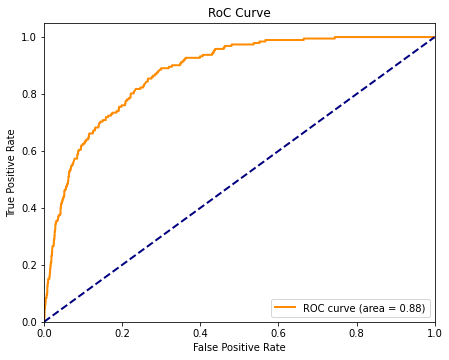

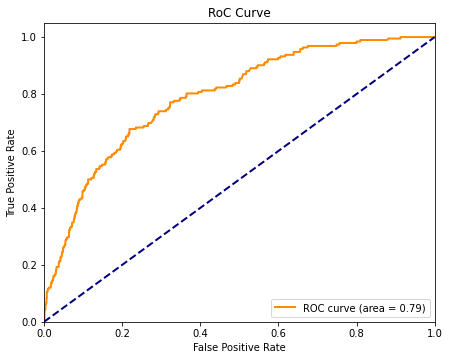

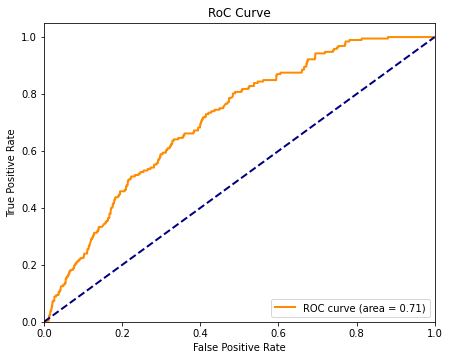

[0 1]
training time: 9.252096176147461s
0.8497123992384656
0.8104866258894696
0.743779452073291
0.9521662910092662
0.9509140996744303
0.9511645379413974
0.62


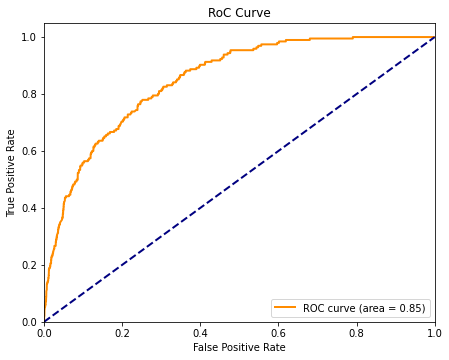

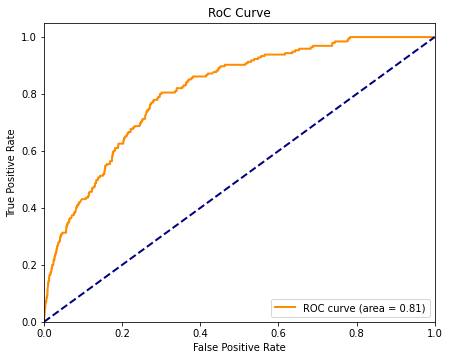

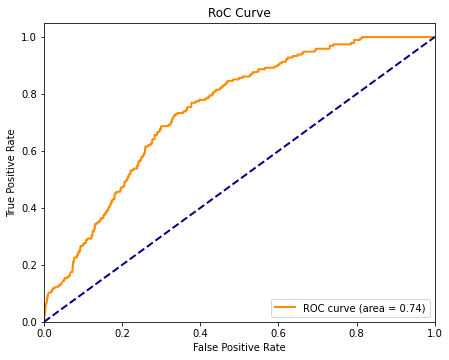

[0 1]
training time: 8.723625421524048s
0.8740271122895591
0.8376248683231908
0.7135182660963667
0.9466032249537404
0.9460745440126883
0.9466032249537404
0.64


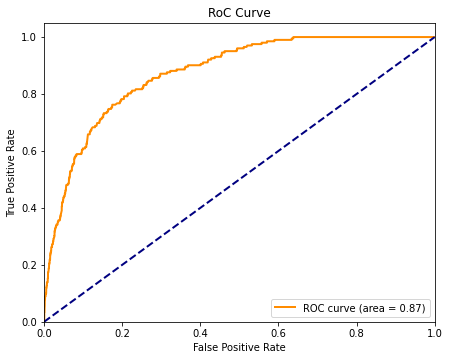

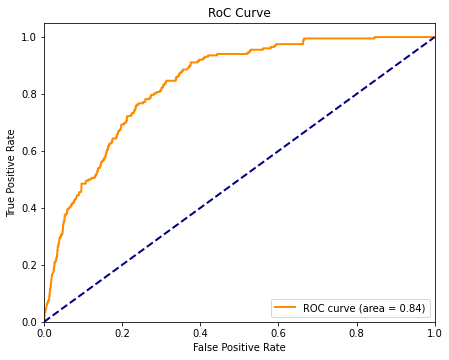

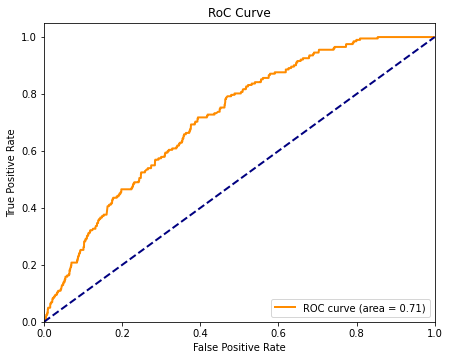

[0 1]
training time: 7.5680670738220215s
0.8640291405749224
0.8083626437442817
0.723193985613245
0.9466032249537404
0.9460745440126883
0.9460745440126883
0.64


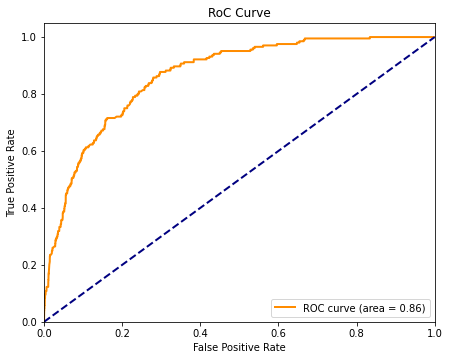

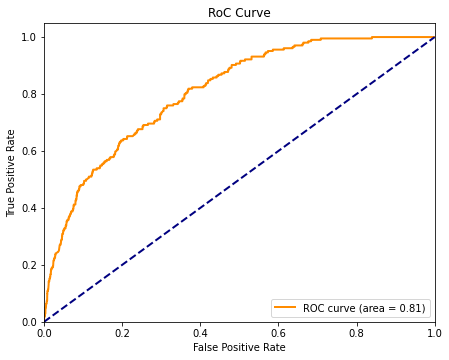

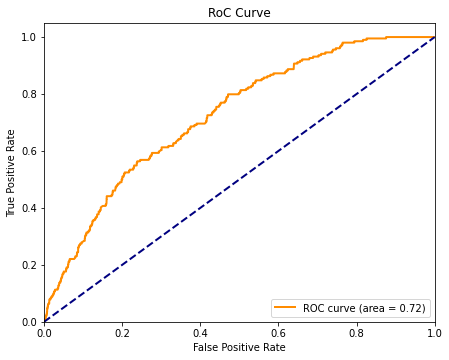

[0 1]
training time: 7.665069818496704s
0.8653226059901316
0.8201789811119142
0.7112723529966373
0.9476630282675623
0.947103274559194
0.9473831514133781
0.66


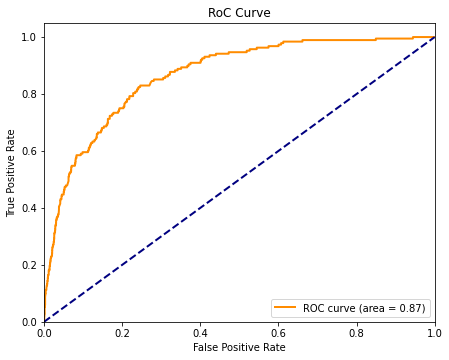

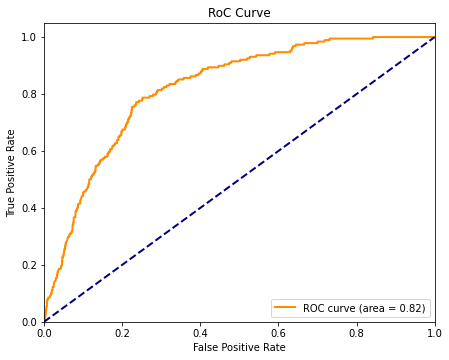

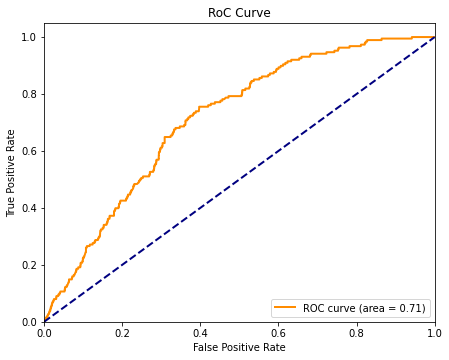

[0 1]
training time: 9.62415623664856s
0.8656140943374985
0.7986376912204336
0.7304409483783006
0.9465435208508256
0.9468233977050098
0.947103274559194
0.66


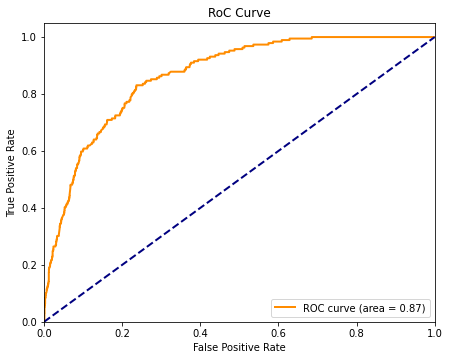

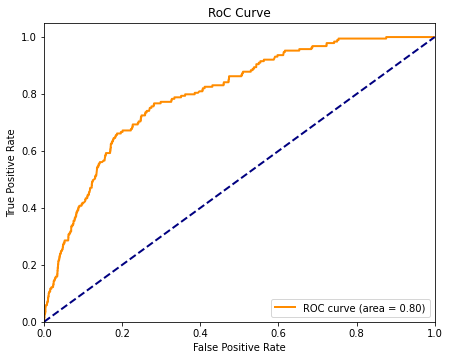

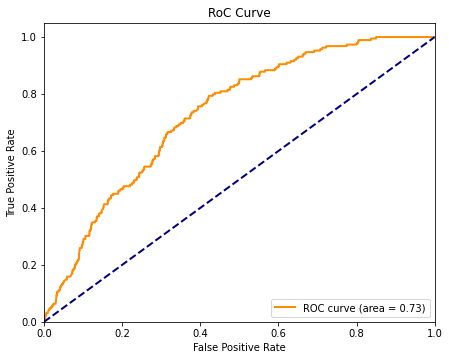

[0 1]
training time: 9.24764108657837s
0.8695536239533336
0.8318470625534902
0.7052373176752599
0.9485425342058299
0.9491374182034503
0.9491374182034503
0.68


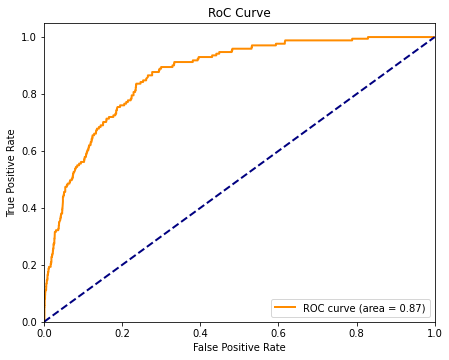

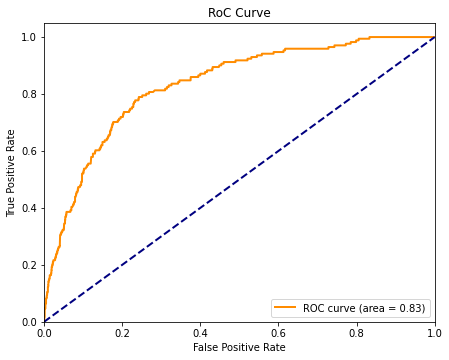

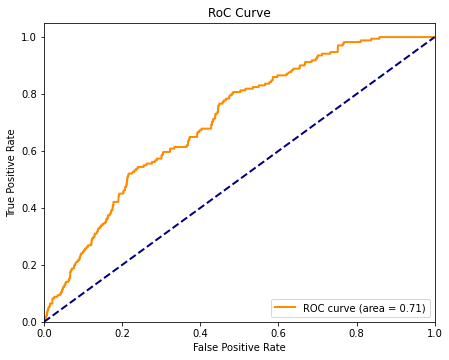

[0 1]
training time: 7.331921815872192s
0.8603821724639217
0.7810697494272797
0.7154314029606035
0.9452706722189174
0.9455681142177276
0.946162998215348
0.68


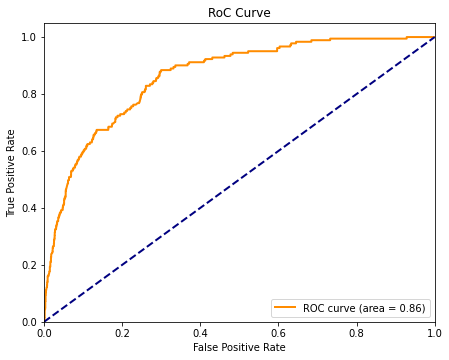

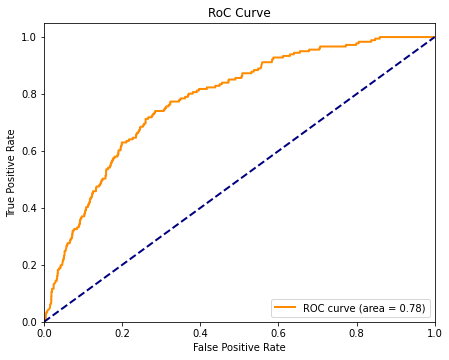

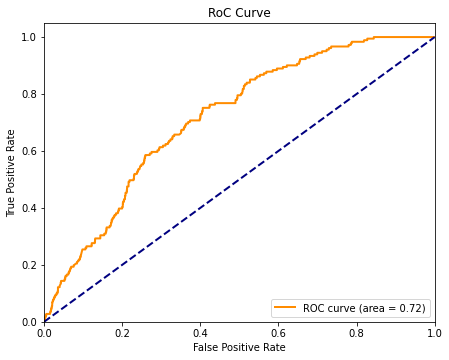

[0 1]
training time: 6.948625564575195s
0.8456492898392384
0.7855216950210707
0.7096613079444357
0.9447969543147208
0.9428934010152284
0.9454314720812182
0.70


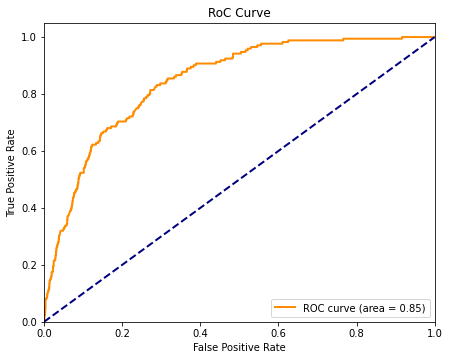

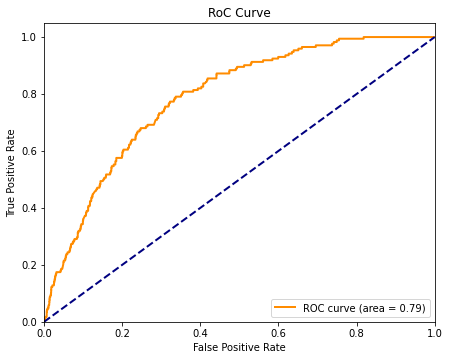

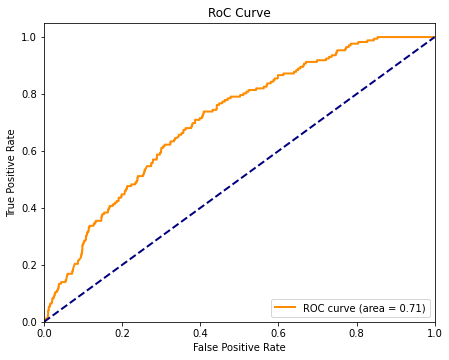

[0 1]
training time: 9.054856300354004s
0.8810877438597561
0.792094023597204
0.7059388664008683
0.9476522842639594
0.9479695431472082
0.9476522842639594
0.70


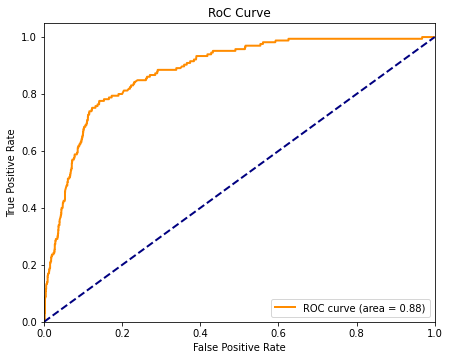

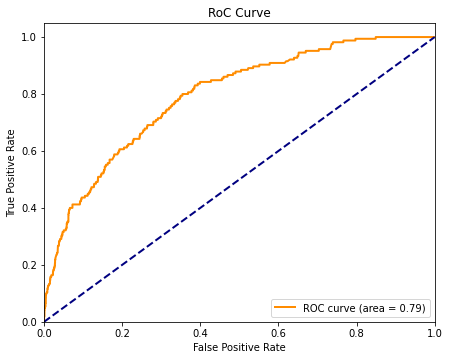

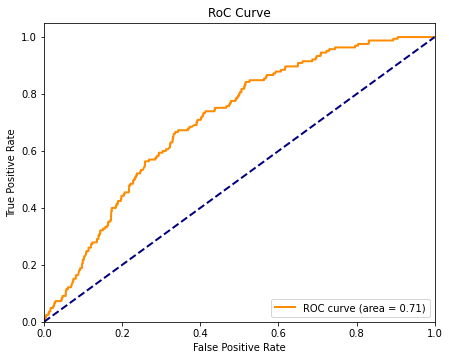

[0 1]
training time: 8.379044532775879s
0.8677936385222816
0.8003271853774366
0.6755618753106191
0.947654656696125
0.9466349422161795
0.946974847042828
0.72


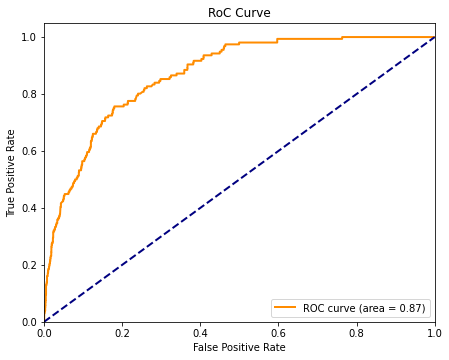

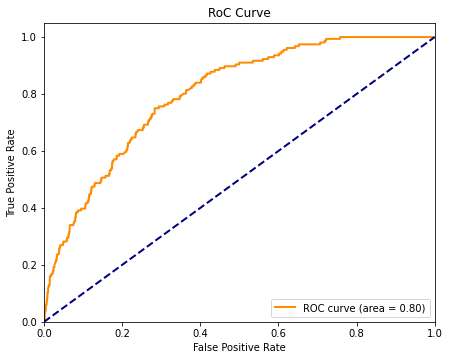

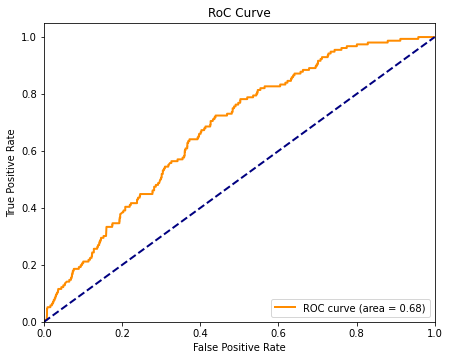

[0 1]
training time: 9.961393117904663s
0.8789186960815369
0.8367970802511693
0.7120742421136969
0.9483344663494222
0.9473147518694766
0.947654656696125
0.72


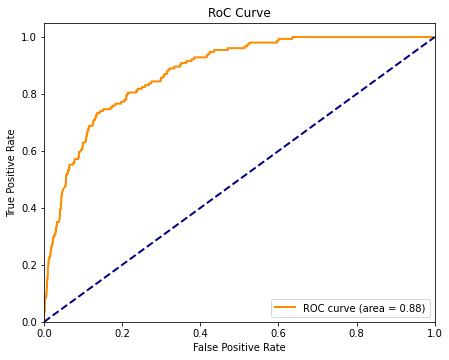

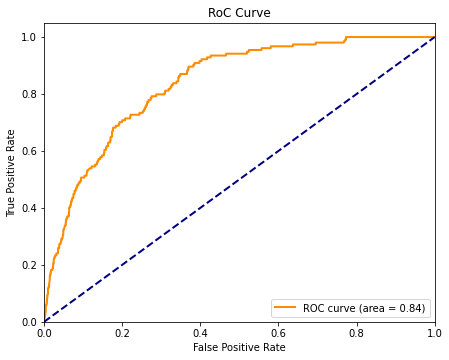

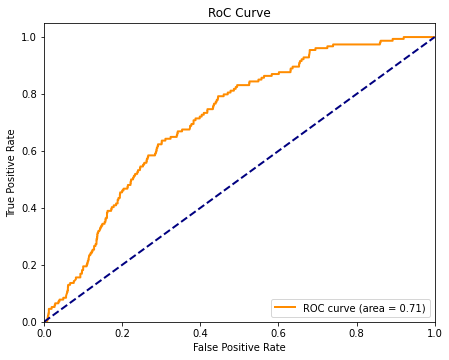

[0 1]
training time: 6.950510025024414s
0.8667214908007181
0.8279678434368236
0.723274533799988
0.945095168374817
0.9447291361639825
0.9454612005856515
0.74


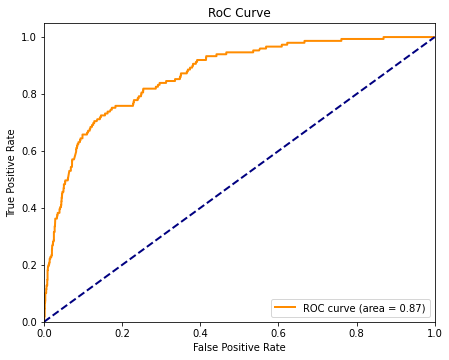

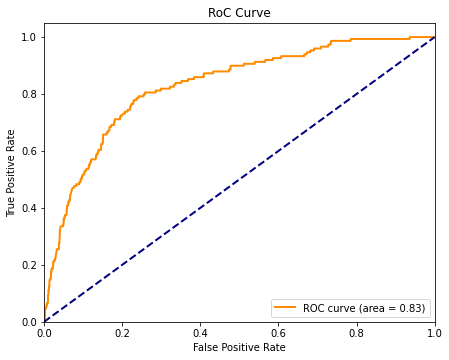

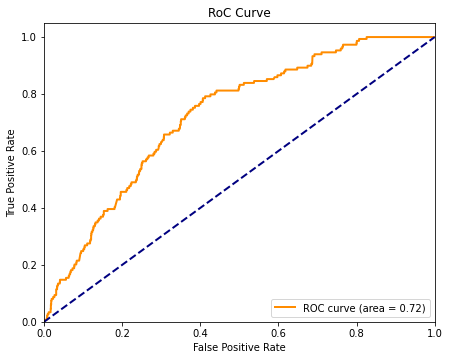

[0 1]
training time: 7.5994298458099365s
0.8836493481253985
0.8208419214356295
0.7012052084274262
0.948389458272328
0.9480234260614934
0.948389458272328
0.74


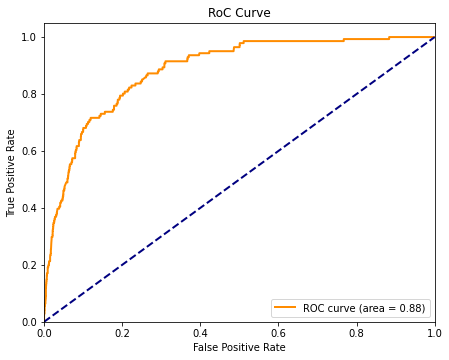

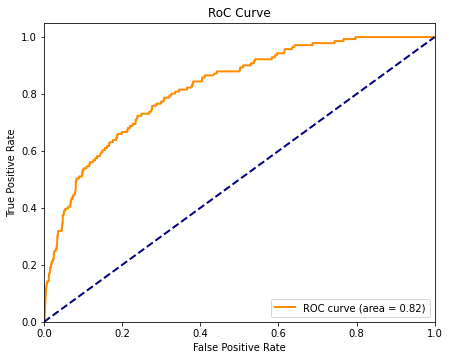

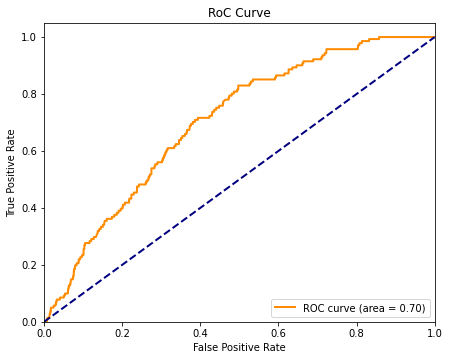

[0 1]
training time: 9.123607635498047s
0.8490778076821157
0.8104437441933969
0.7086466105401616
0.9488501189532117
0.9480570975416336
0.9480570975416336
0.76


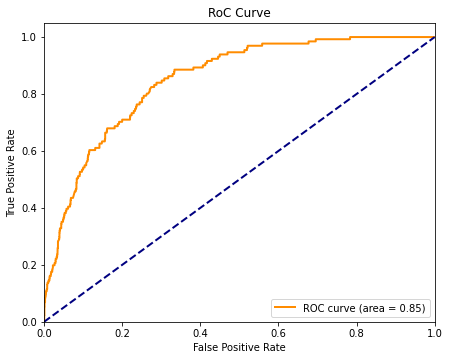

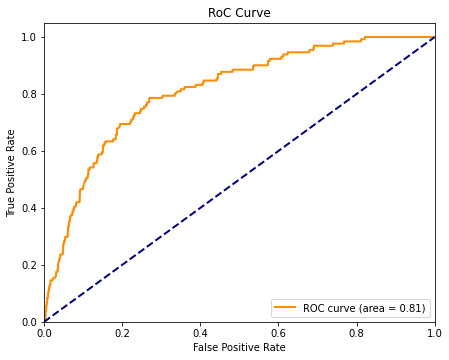

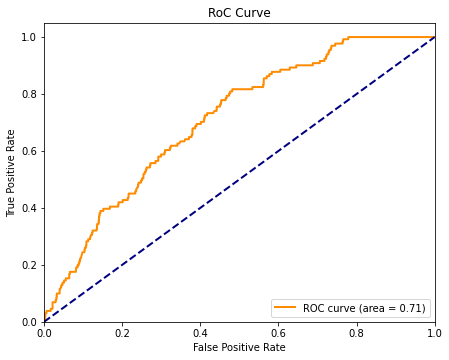

[0 1]
training time: 6.937333583831787s
0.8957620342235726
0.8127547666009205
0.7249604634220019
0.9528152260111022
0.9524187153053132
0.9536082474226805
0.76


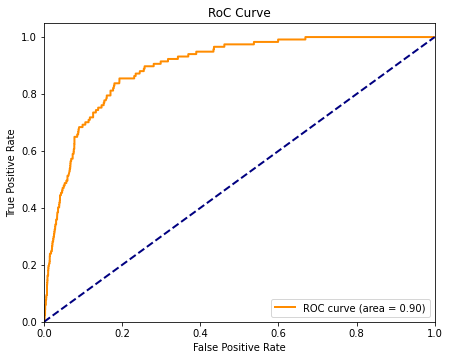

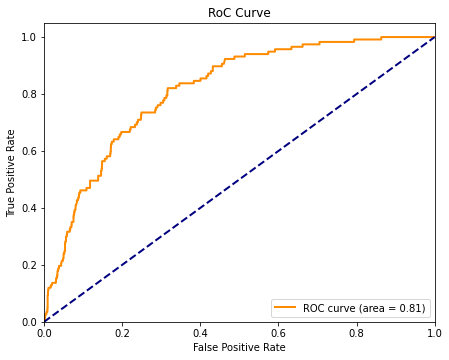

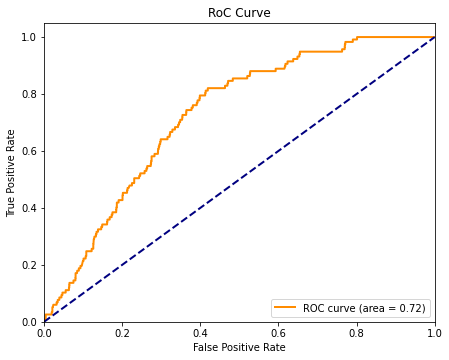

[0 1]
training time: 10.425439834594727s
0.8534622245445864
0.7890754788374565
0.6900574785131264
0.9450692041522492
0.9446366782006921
0.9450692041522492
0.78


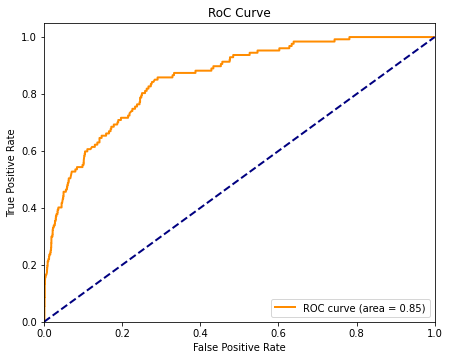

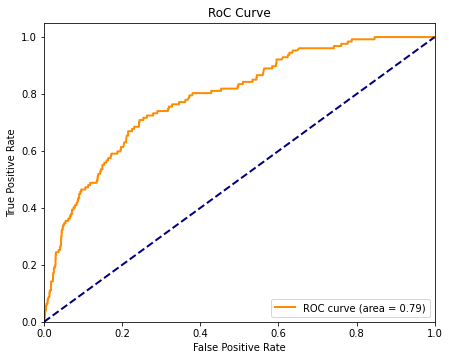

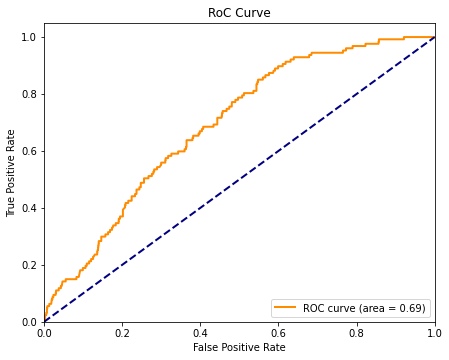

[0 1]
training time: 6.486941337585449s
0.8710181747117453
0.7835933278920324
0.7018205366962107
0.948961937716263
0.9485294117647058
0.9485294117647058
0.78


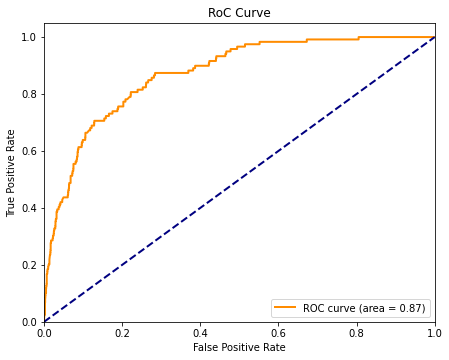

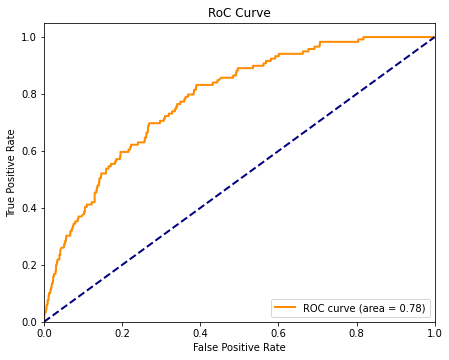

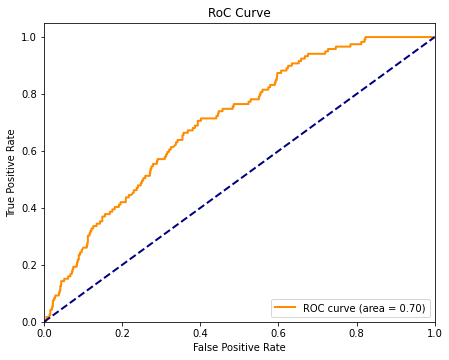

[0 1]
training time: 12.854981899261475s
0.872624656851622
0.7969206743282745
0.664261847239463
0.9471931493815414
0.9471931493815414
0.9462416745956232
0.80


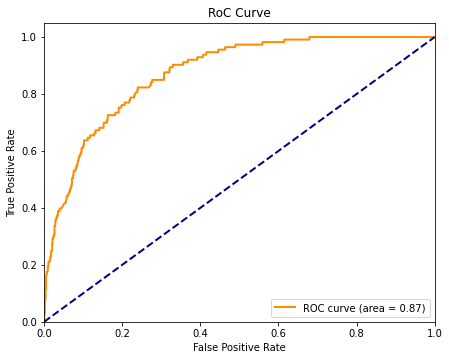

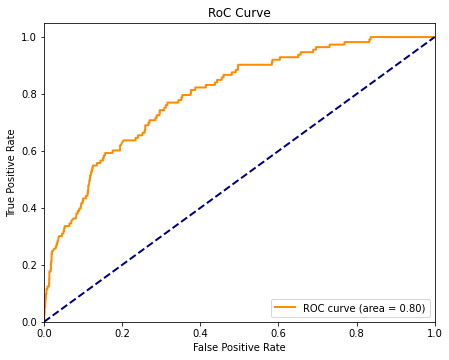

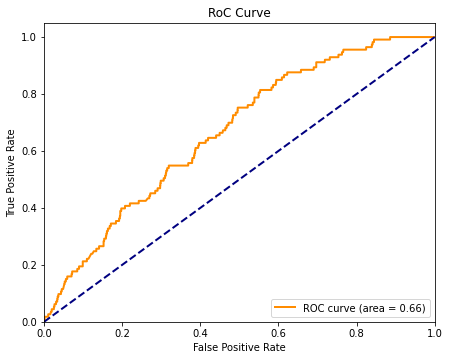

[0 1]
training time: 6.652243614196777s
0.8689915826120133
0.7637146195483702
0.7055559529770847
0.950523311132255
0.9500475737392959
0.9500475737392959
0.80


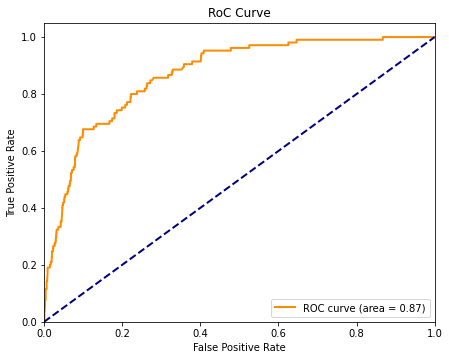

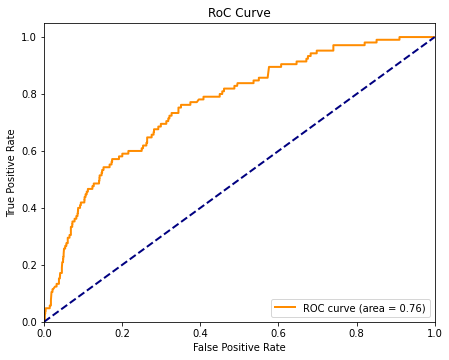

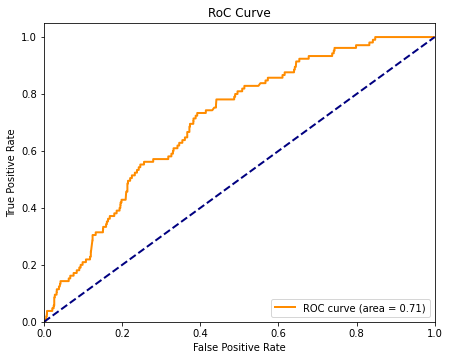

[0 1]
training time: 9.17622685432434s
0.8719653911977857
0.8044433645333728
0.698567474487101
0.9445031712473573
0.945031712473573
0.9439746300211417
0.82


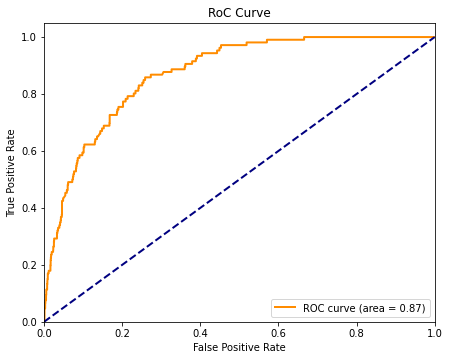

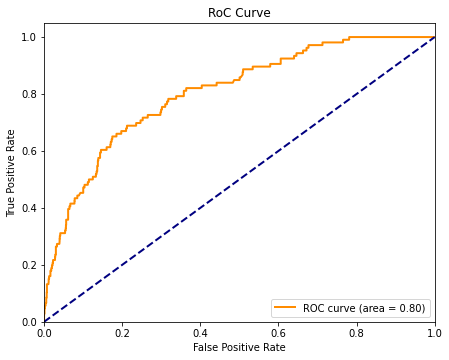

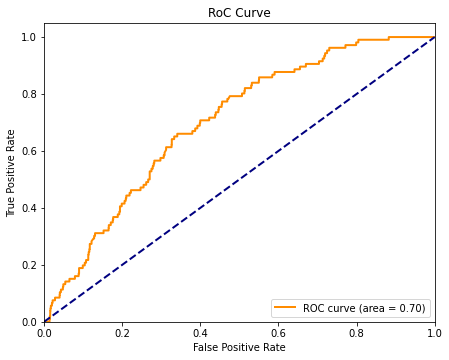

[0 1]
training time: 6.852297306060791s
0.8650882825040128
0.8003611556982344
0.7178772070626003
0.9423890063424947
0.9402748414376322
0.9408033826638478
0.82


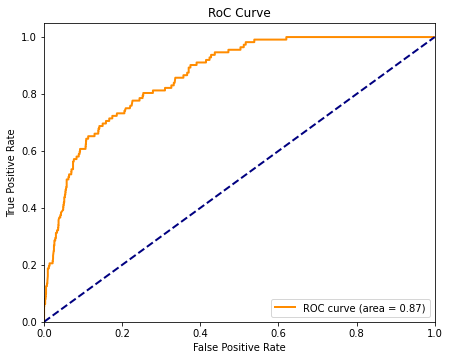

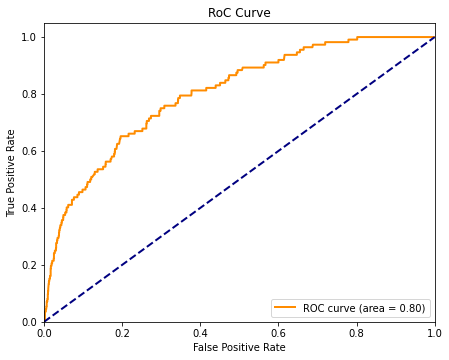

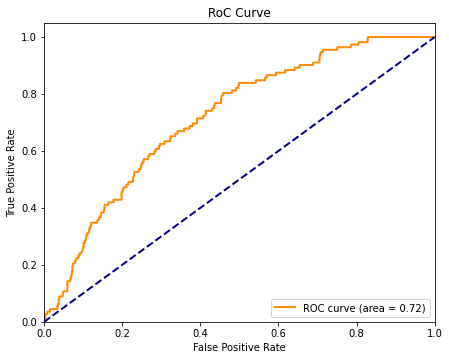

[0 1]
training time: 11.544307231903076s
0.8371164233996092
0.7740585373328737
0.7470565324547626
0.9405116002379535
0.9405116002379535
0.9411064842355741
0.84


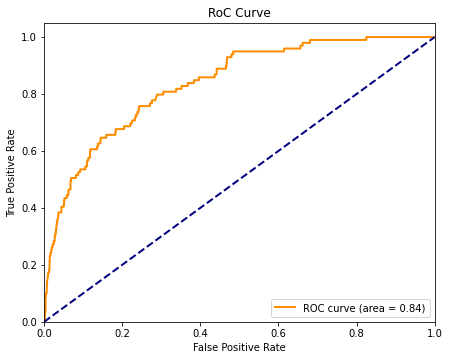

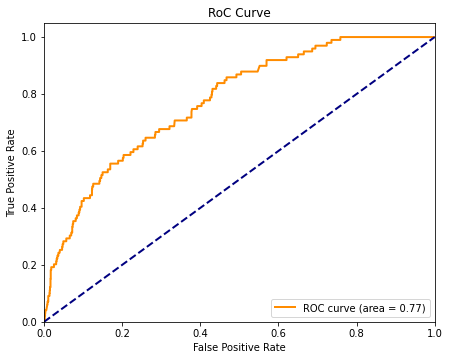

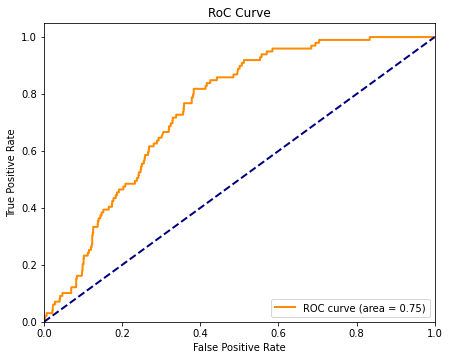

[0 1]
training time: 9.263629913330078s
0.8546152899006759
0.7590602511834077
0.7067303745861494
0.9440809042236764
0.9440809042236764
0.9452706722189174
0.84


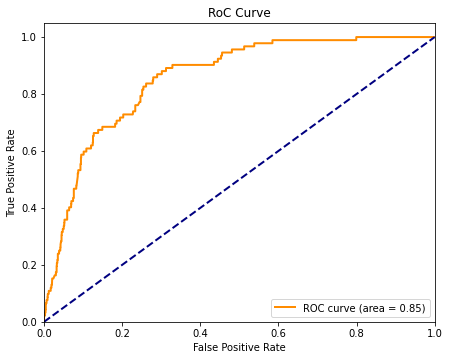

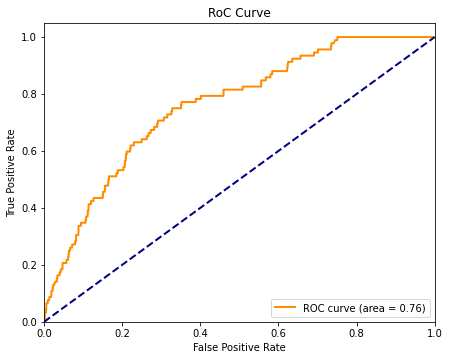

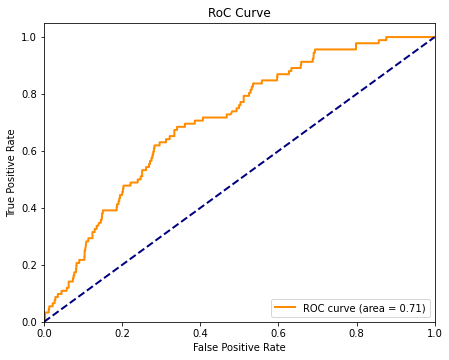

[0 1]
training time: 9.195471048355103s
0.8913665244368257
0.8554239877769291
0.7196845478768004
0.9483344663494222
0.9456152277362339
0.947654656696125
0.86


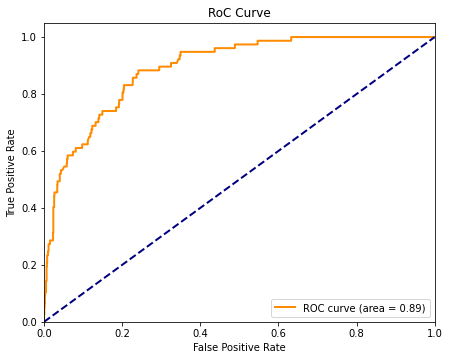

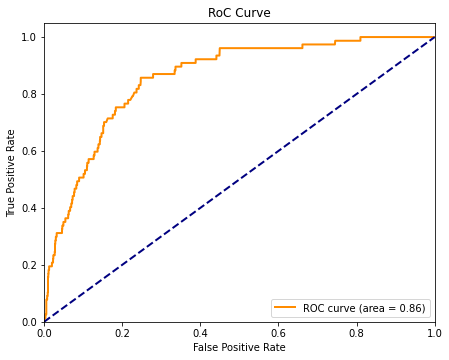

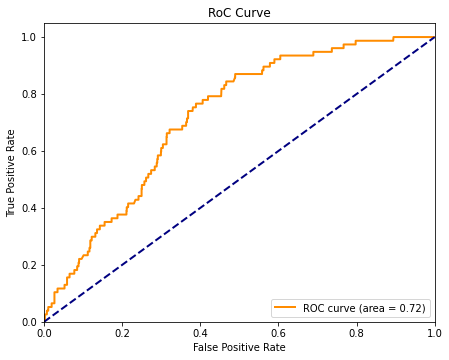

[0 1]
training time: 11.173837423324585s
0.9173396553482206
0.8383450596512695
0.7062455389007851
0.9503738953093134
0.9510537049626104
0.9524133242692047
0.86


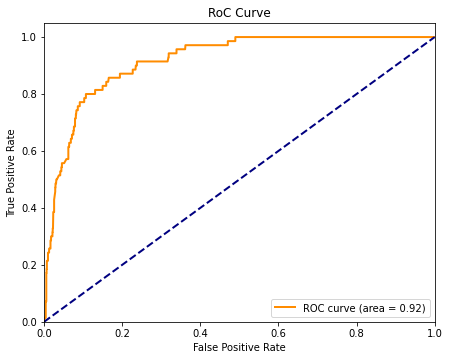

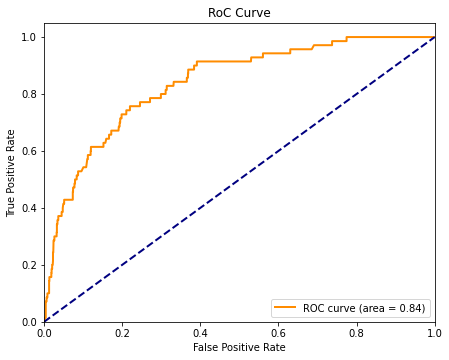

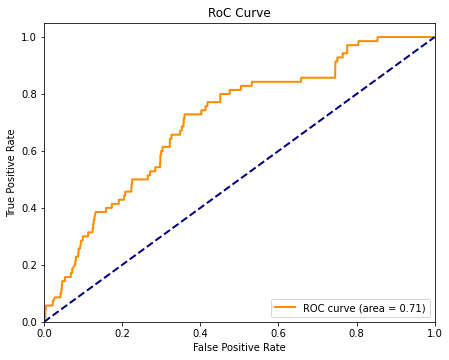

[0 1]
training time: 11.117485046386719s
0.8803845096127404
0.8228205705142629
0.7631315782894573
0.9492466296590008
0.9468675654242664
0.9468675654242664
0.88


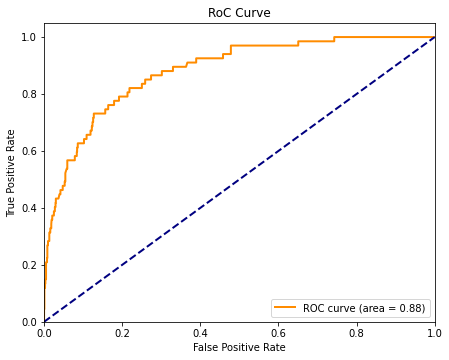

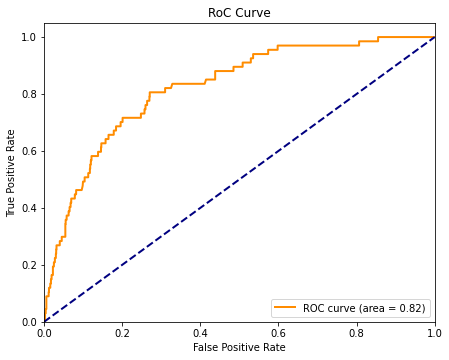

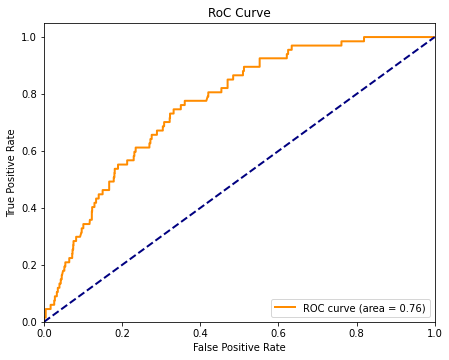

[0 1]
training time: 8.44518494606018s
0.8574140267264743
0.7806805438744042
0.6964360807401178
0.9413164155432197
0.9452815226011102
0.9429024583663759
0.88


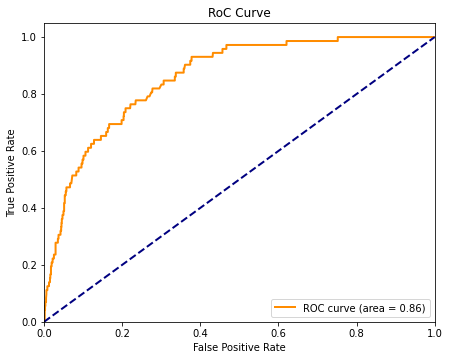

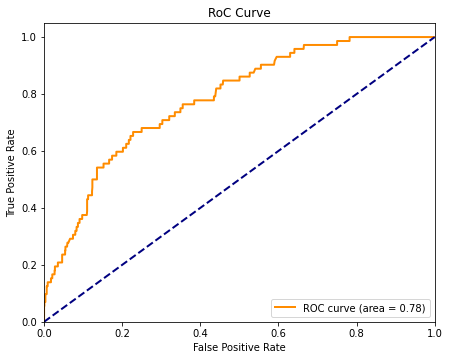

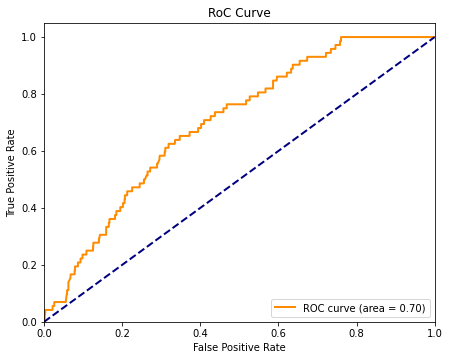

[0 1]
training time: 9.222880363464355s
0.844786411032627
0.8007399932727884
0.7340060544904137
0.9429115128449096
0.9419600380589914
0.9429115128449096
0.90


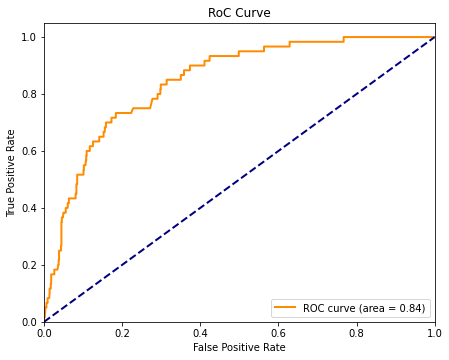

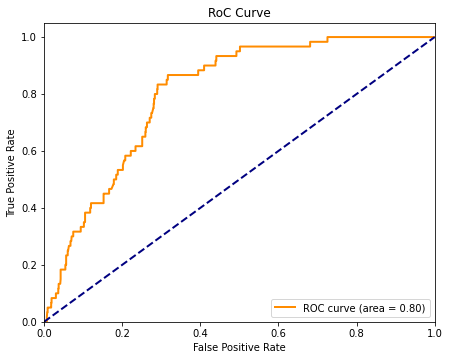

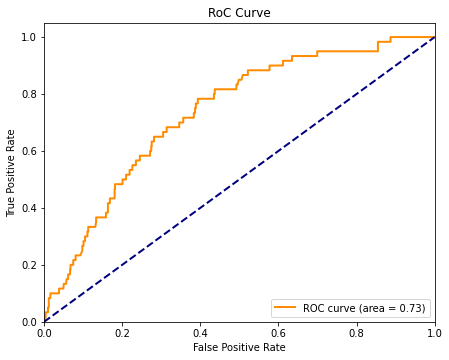

[0 1]
training time: 8.875733852386475s
0.8415962907766186
0.7682563338301043
0.6844676270905778
0.9429115128449096
0.9419600380589914
0.9419600380589914
0.90


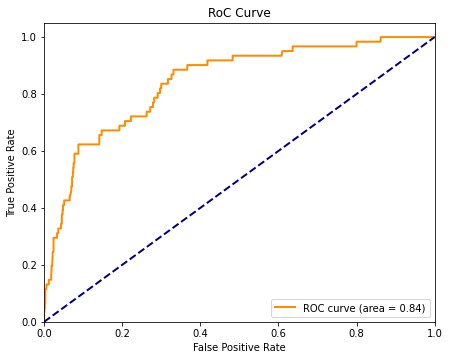

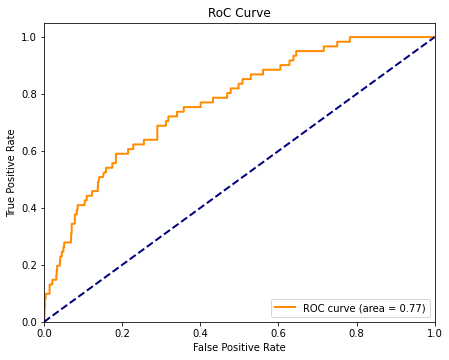

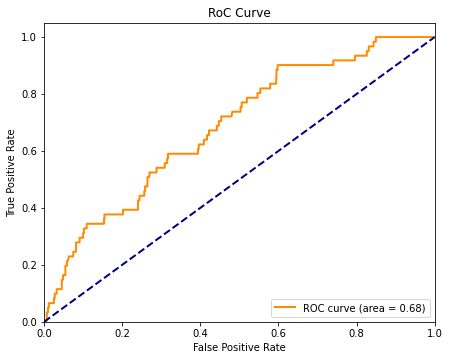

[0 1]
training time: 9.205342531204224s
0.9214481707317073
0.7819664634146343
0.7319054878048781
0.9536266349583828
0.9524375743162902
0.9512485136741974
0.92


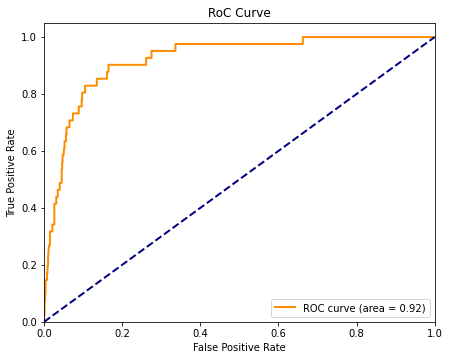

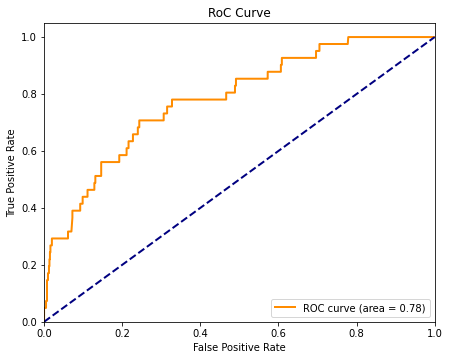

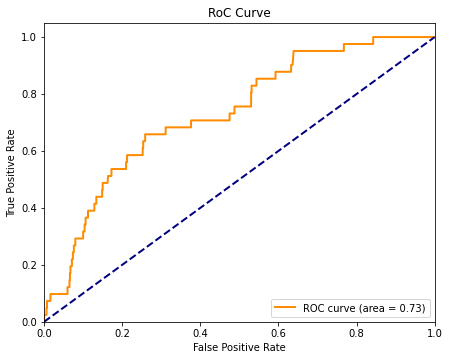

[0 1]
training time: 11.791425704956055s
0.9028294862248698
0.8020104244229337
0.6900223380491436
0.9405469678953626
0.93935790725327
0.93935790725327
0.92


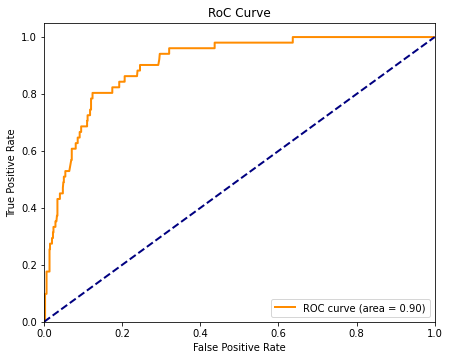

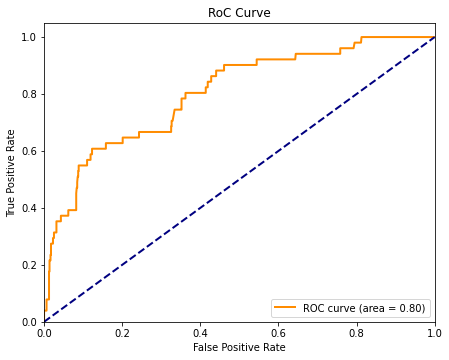

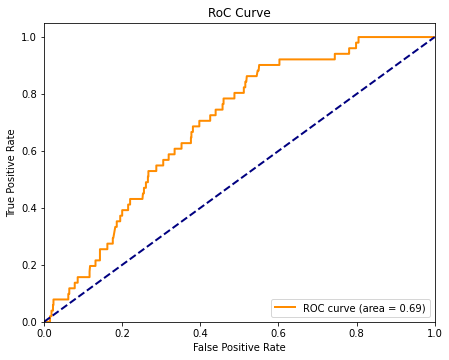

[0 1]
training time: 9.403326272964478s
0.8901881720430107
0.8248118279569892
0.6619623655913979
0.9508716323296355
0.9508716323296355
0.9508716323296355
0.94


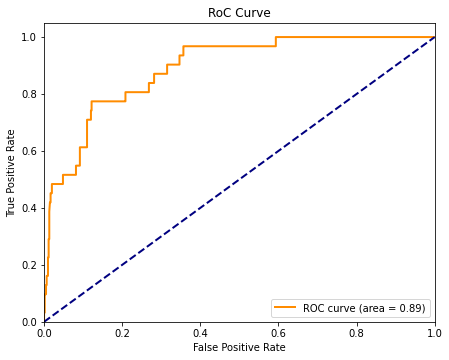

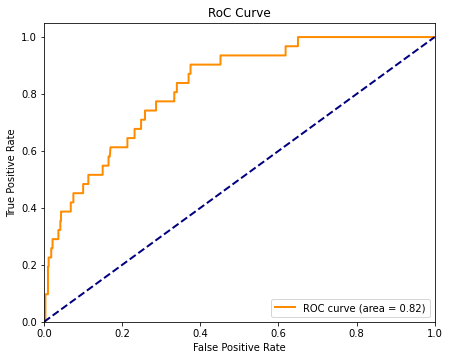

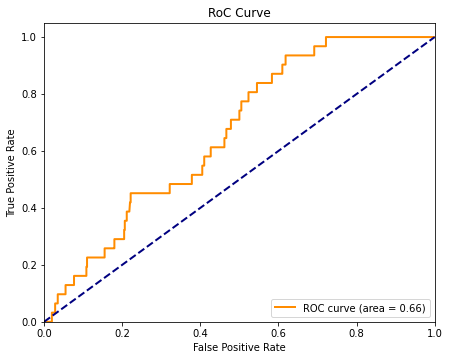

[0 1]
training time: 10.262677431106567s
0.8879199921174501
0.8025421223765888
0.7003153020001971
0.9461172741679873
0.9461172741679873
0.9461172741679873
0.94


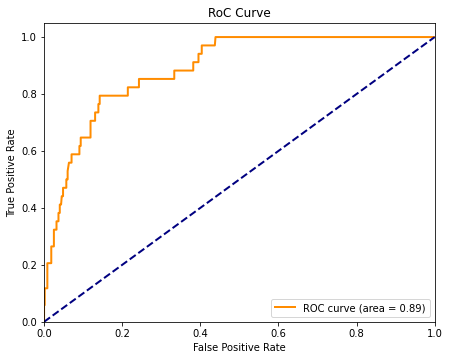

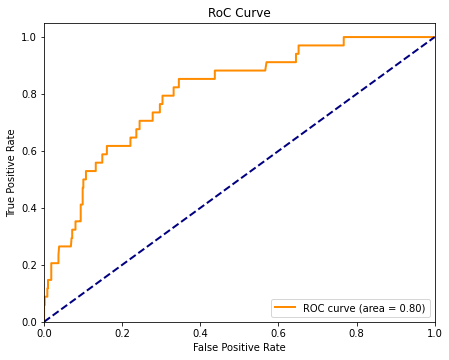

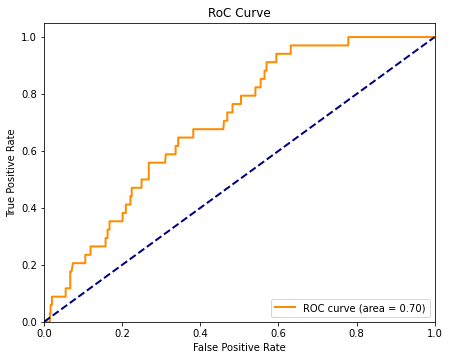

[0 1]
training time: 9.598803281784058s
0.883989898989899
0.8466161616161616
0.7400505050505051
0.9453681710213777
0.9406175771971497
0.9406175771971497
0.96


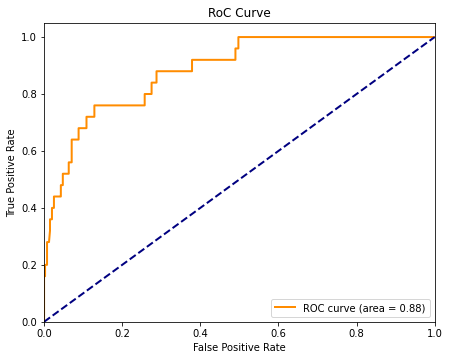

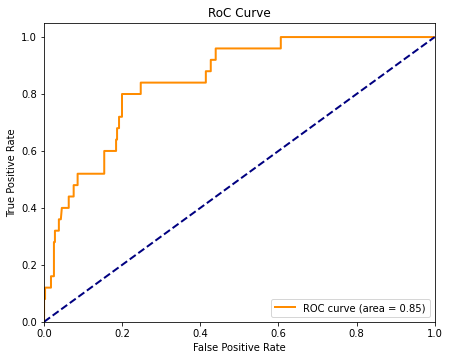

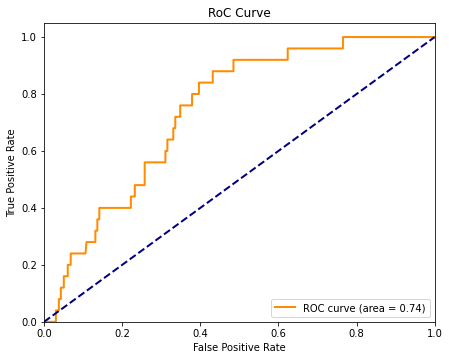

[0 1]
training time: 9.171108722686768s
0.8691615402141718
0.804226475279107
0.7502278423331055
0.9501187648456056
0.9453681710213777
0.9477434679334917
0.96


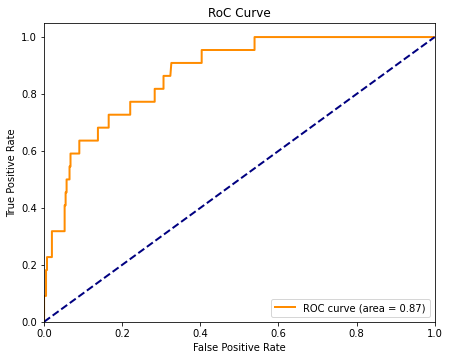

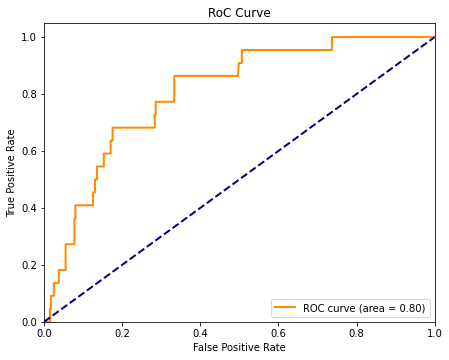

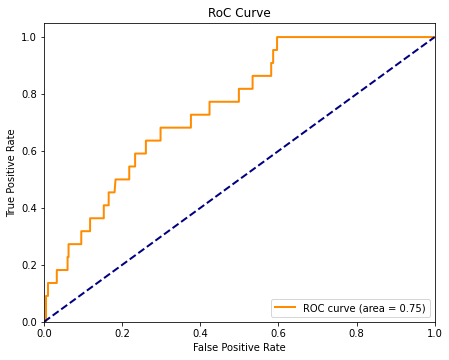

[0 1]
training time: 10.85927677154541s
0.8168316831683168
0.8635863586358636
0.5071507150715071
0.95260663507109
0.957345971563981
0.957345971563981
0.98


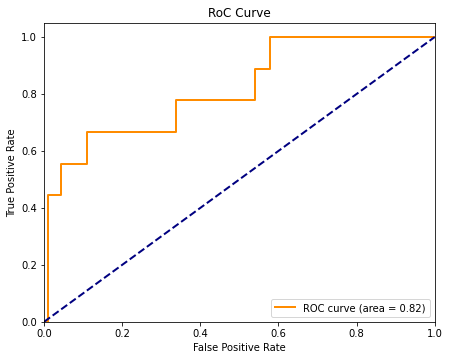

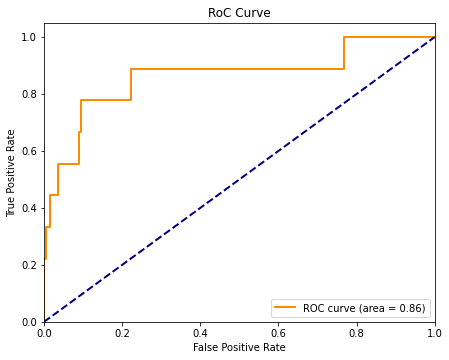

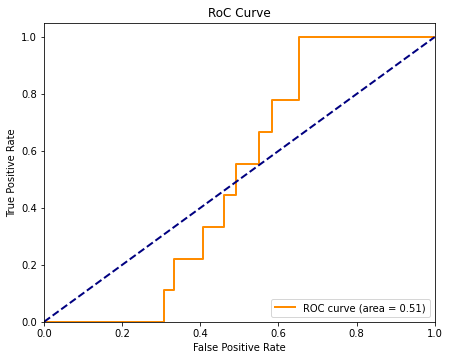

[0 1]
training time: 9.204590320587158s
0.9133165829145728
0.8634840871021776
0.541038525963149
0.95260663507109
0.943127962085308
0.943127962085308
0.98


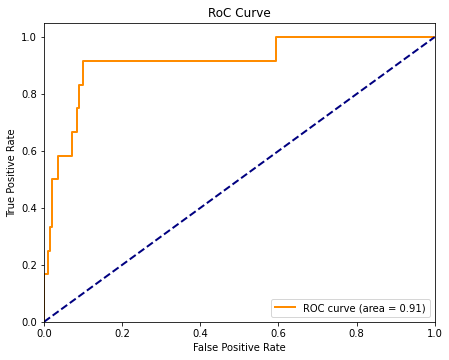

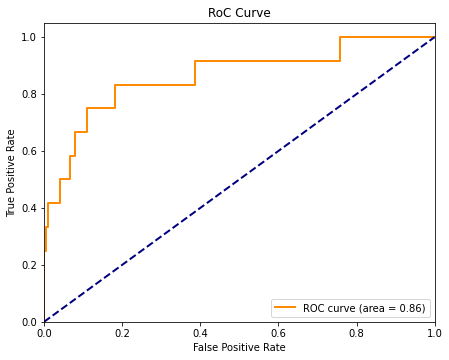

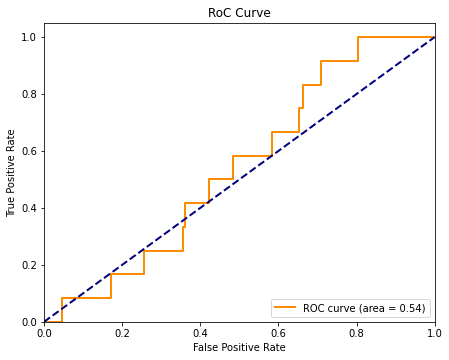

In [31]:
num=30
xax = []
yauc = []
yacc = []
for j in range(30,49):
    num+=1
    auc,acc = solve( int(tot*num/50),train0 )
    xax.append(num/20)
    yauc.append(auc)
    yacc.append(acc)

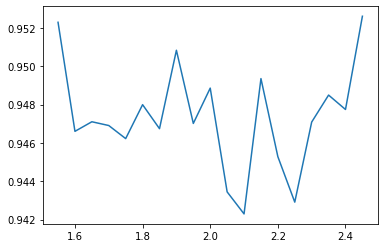

In [32]:
plt.plot(xax,yacc)
plt.show()



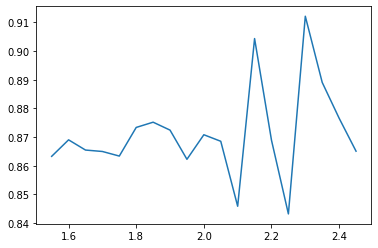

In [33]:
plt.plot(xax,yauc)
plt.show()

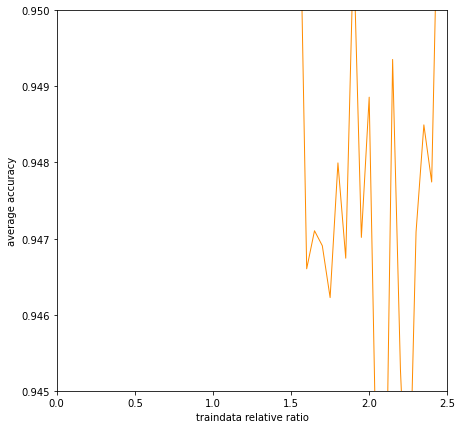

In [34]:
plt.subplots(figsize=(7,7))
plt.plot(xax,yacc,color='darkorange', lw =1 )
plt.xlim([0.0,2.5])
plt.ylim([0.945,0.95])
plt.xlabel('traindata relative ratio')
plt.ylabel('average accuracy')
plt.show()

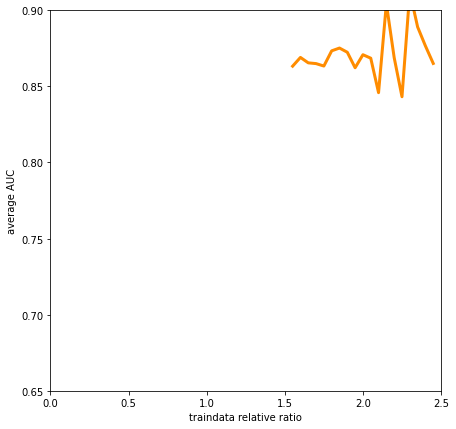

In [35]:
plt.subplots(figsize=(7,7))
plt.plot(xax,yauc,color='darkorange', lw =3 )
plt.xlim([0.0,2.5])
plt.ylim([0.650,0.90])
plt.xlabel('traindata relative ratio')
plt.ylabel('average AUC')
plt.show()